# Required Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn import metrics
from sklearn.inspection import plot_partial_dependence
import shap
from sklearn.inspection import permutation_importance


# Data Loading

In [3]:
data = pd.read_csv('/kaggle/input/kc-house-data/kc_house_data.csv')
data.head(1)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650


# EDA and Preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

> There are only two NaN values present in the 'sqft_living' feature, and given that the number of missing values is relatively small, we can opt to remove these observations from the dataset.

In [5]:
data.dropna(subset=['sqft_living'], inplace=True)

In [6]:
data.drop(columns=['id']).describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21611.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.396095,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.128162,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


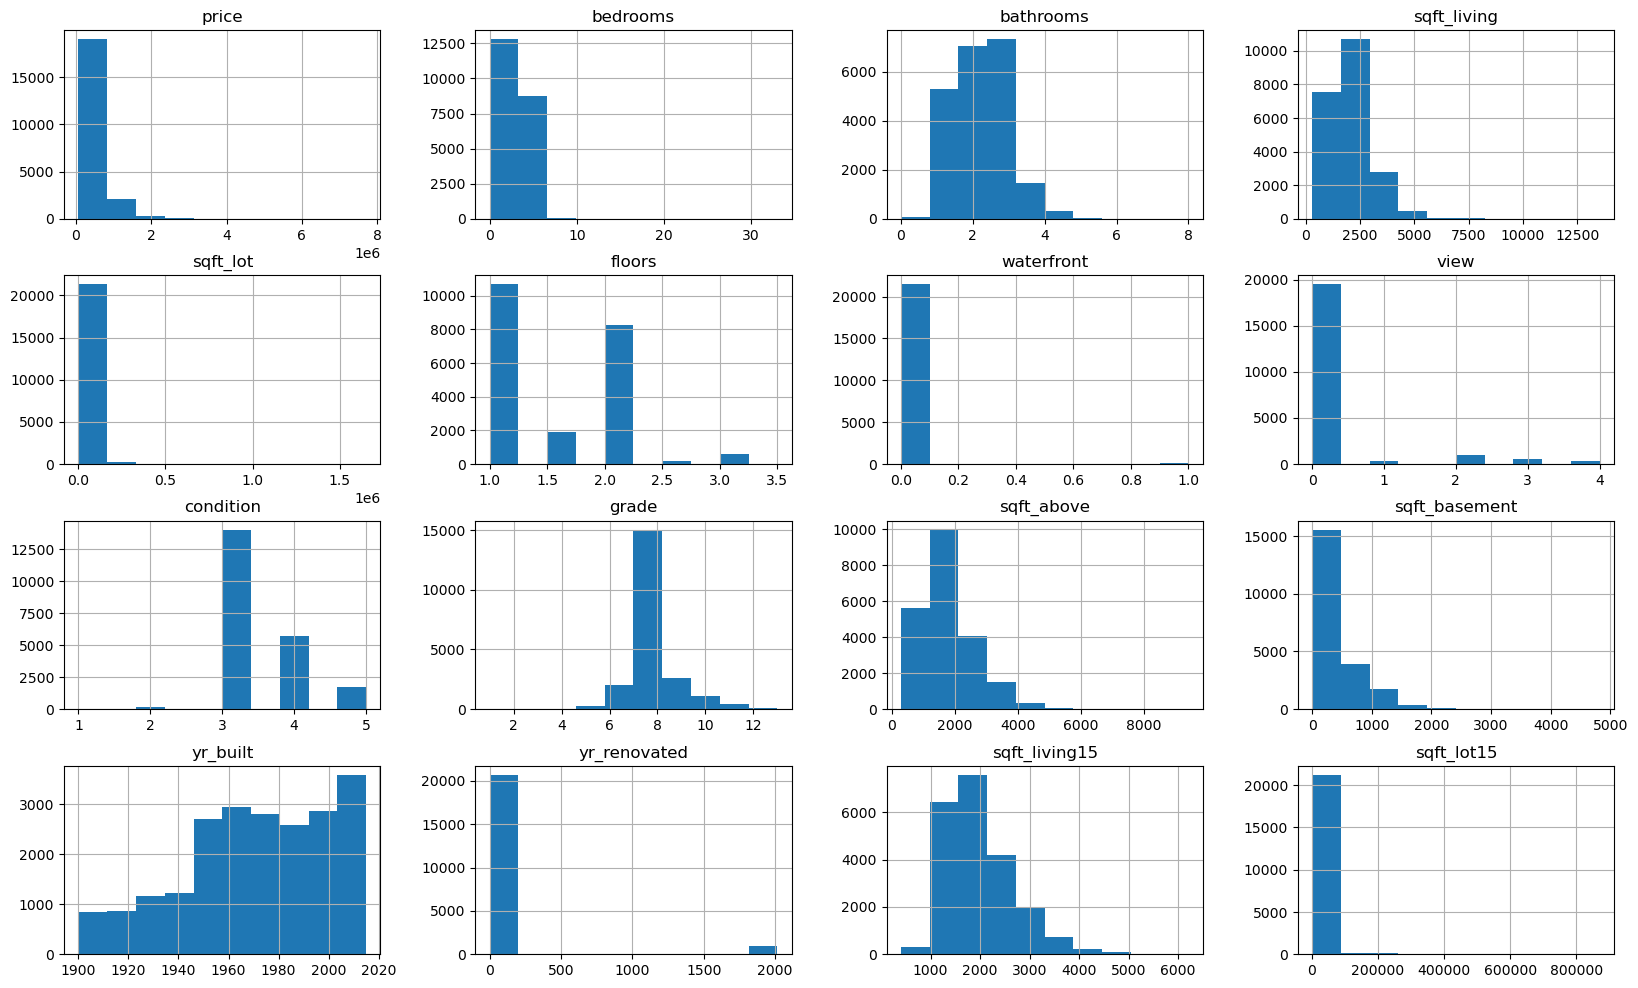

In [7]:
data.drop(columns=['id', 'zipcode', 'long', 'lat']).hist(figsize=(20, 12));

> Skewness in the distribution of certain numeric features can adversely impact the accuracy and performance of machine learning models. As such, it is crucial to implement data preprocessing techniques, such as removing or transforming skewed features, to optimize the data for use in machine learning algorithms. In this case, we addressed the issue of skewness by applying a logarithmic transformation to the relevant features.

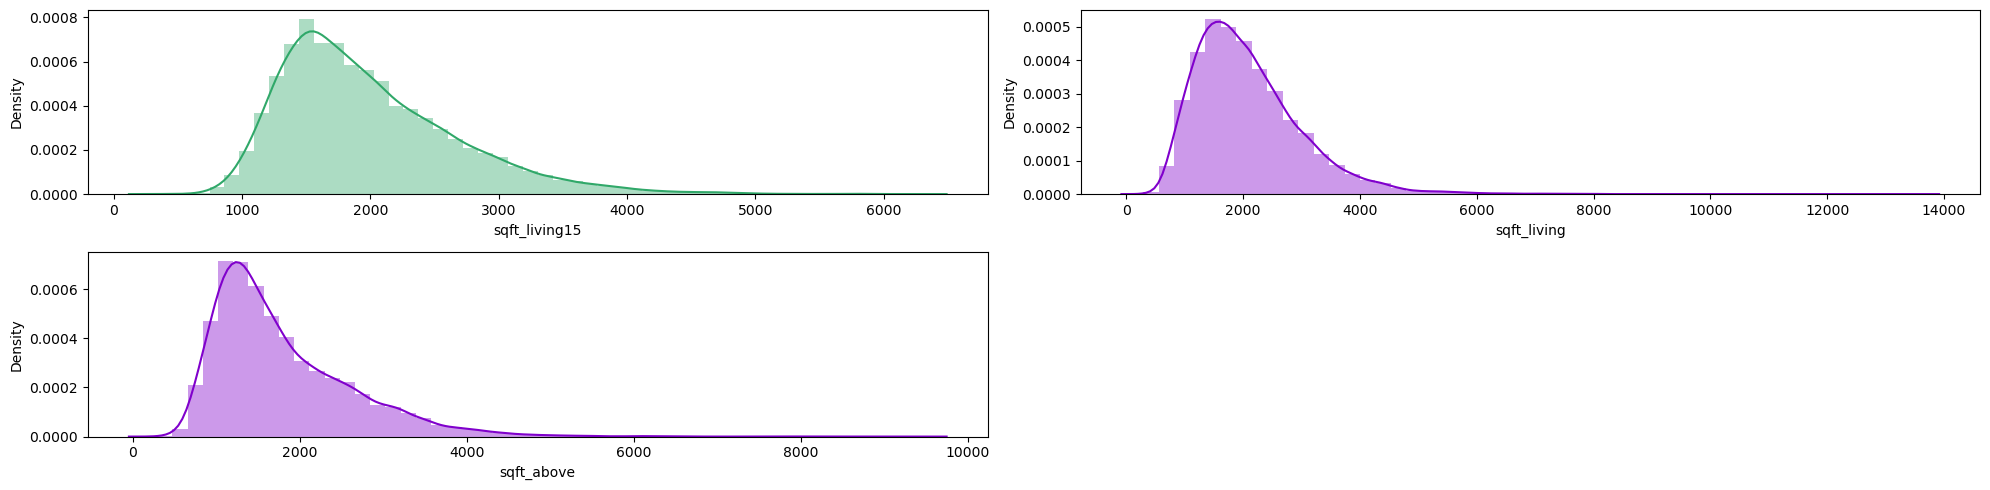

In [8]:
# Plot some of feature including skewness
plt.figure(figsize=(20,5))

plt.subplot(2,2,1)
sns.distplot(data['sqft_living15'], color=(0.188,0.66,0.413))

plt.subplot(2,2,2)
sns.distplot(data['sqft_living'], color=(0.5,0,0.8))

plt.subplot(2,2,3)
sns.distplot(data['sqft_above'], color=(0.5,0,0.8));

plt.tight_layout()

In [9]:
data_log = data.copy()
skewness_columns = ['sqft_living15', 'sqft_basement', 'sqft_basement', 'sqft_above', 'sqft_living']
for column in skewness_columns:
    data_log[column] = data_log[column].map(lambda i: np.log(i) if i > 0 else 0)

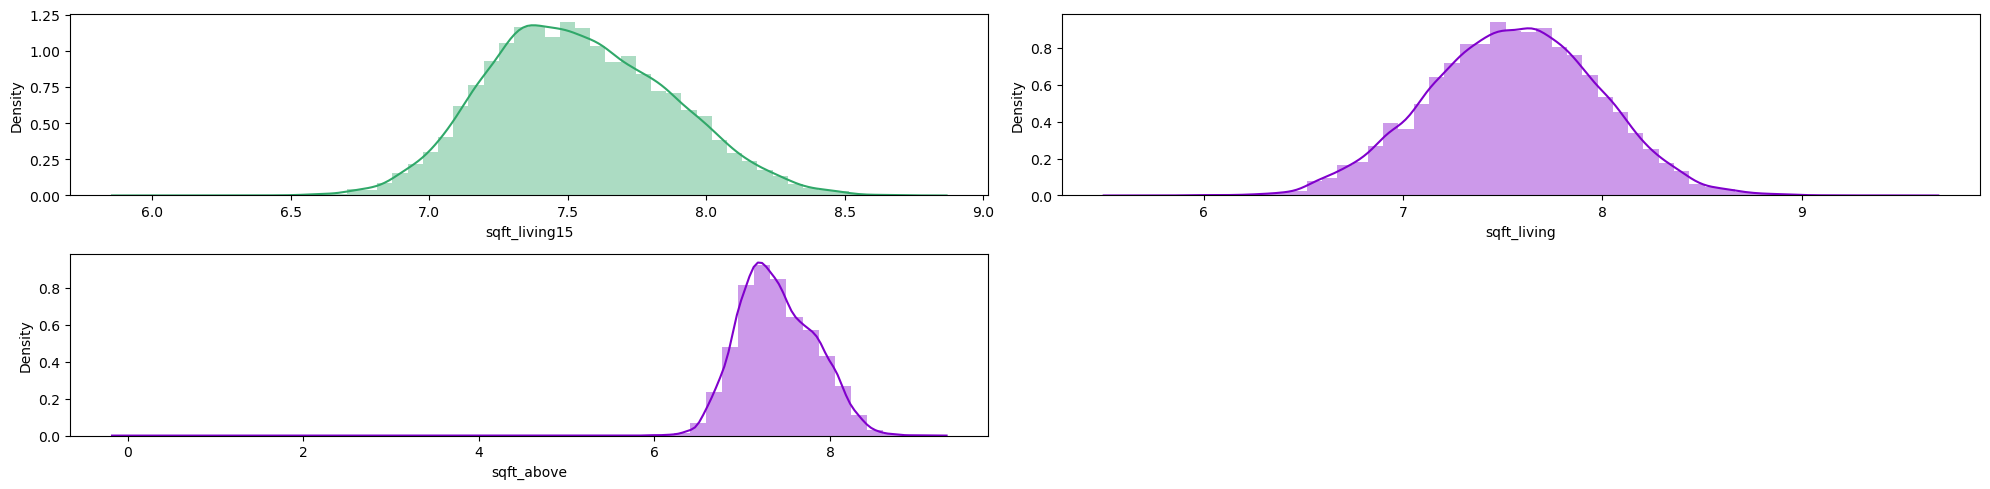

In [10]:
# Plot after removing skewness
plt.figure(figsize=(20,5))

plt.subplot(2,2,1)
sns.distplot(data_log['sqft_living15'], color=(0.188,0.66,0.413))

plt.subplot(2,2,2)
sns.distplot(data_log['sqft_living'], color=(0.5,0,0.8))

plt.subplot(2,2,3)
sns.distplot(data_log['sqft_above'], color=(0.5,0,0.8));

plt.tight_layout()

# Regression

In [11]:
X = data_log.iloc[:, 3:].values
y = data_log['price'].values

In [12]:
X.shape

(21613, 18)

Linear Regression 


In [14]:
from sklearn.linear_model import LinearRegression

In [16]:
linear_model = LinearRegression()
linear_model.fit(X, y)

LinearRegression()

In [19]:
linear_model_score = linear_model.score(X,y)
linear_model_score

0.6622232813793343

In [ ]:
data_matrix = xgb.DMatrix(data=X, label=y)

In [ ]:
data_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
xg_reg = xgb.XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=1000, verbosity=0)

In [ ]:
xg_reg.fit(X_train, y_train)

In [ ]:
y_pred = xg_reg.predict(X_test)

In [ ]:
metrics.mean_absolute_error(y_test, y_pred)

In [ ]:
metrics.r2_score(y_test, y_pred)

# Model Analysis

## 1. Feature importance

### 1.1. XGB

In [ ]:
xg_reg.get_booster().feature_names = data_log.iloc[:, 3:].columns.to_list()
xgb.plot_importance(xg_reg)

### 1.2. Using inspection library
Permutation Importance is a technique for measuring the importance of each feature in a machine learning model by randomly shuffling the values of each feature and observing the effect on the model's performance. The basic idea is that if a feature is important for making accurate predictions, then shuffling its values should significantly reduce the model's performance.

The resulting permutation importances show the decrease in the model's performance (as measured by the scoring function) when each feature is randomly shuffled. Features that have a large impact on the model's performance (i.e., that result in a large decrease in performance when shuffled) are considered to be more important than features that have a small impact on the model's performance.

Permutation Importance can be useful for identifying which features are most important for making accurate predictions, and can help to identify potential interactions between features. It is a model-agnostic technique, meaning it can be used with any type of machine learning model (e.g., linear regression, decision trees, neural networks, etc.).

In [ ]:
results = permutation_importance(xg_reg, X_test, y_test)
importance = results.importances_mean
importance

> The permutation importance values range from 0 (indicating that shuffling the feature has no effect on the model's performance) to 1 (indicating that shuffling the feature completely destroys the model's performance).

> Based on the abovementioned results, the feature with the highest importance is the 14th feature (index 13 which is `zipcode`), which has a permutation importance of 0.644, indicating that shuffling this feature has a large negative impact on the model's performance. The next most important feature is the 3rd feature (index 2 which is `sqft_living`), with a permutation importance of 0.179.

### 1.3. SHAP
SHAP (SHapley Additive exPlanations) is a technique for explaining the output of a machine learning model by assigning `importance` values to each feature in a prediction. SHAP values provide a way to decompose the model's output into individual feature contributions, allowing us to better understand how each feature contributes to the model's prediction.

SHAP values can be used to gain a deeper understanding of how a model makes predictions, to identify which features are most important for making accurate predictions, and to identify potential interactions between features.

In [ ]:
# Calculate SHAP values
explainer = shap.Explainer(xg_reg, feature_names=data_log.iloc[:, 3:].columns.to_list())
shap_values = explainer(X)

# Plot SHAP values
shap.summary_plot(shap_values, X)

> Here we are using the SHAP library in Python to compute SHAP values for a trained regression model. The `Explainer` class is used to create an explainer object for the trained model, which can then be used to compute SHAP values for a given set of input features (X_test in this case).

> The resulting SHAP values show the contribution of each feature to the model's prediction for each data point in the test set. A summary plot can be generated using `shap.summary_plot` to visualize the average impact of each feature on the model's predictions across the entire test set.

## 2. Partial Dependence Plots
Partial Dependence Plots (PDPs) are a technique used to visualize the relationship between a target variable and one or more predictor variables in a regression model. PDPs can help to identify non-linear relationships and interactions between predictor variables that may not be apparent from simple scatter plots or correlation matrices.

The resulting PDPs show the predicted response of the target variable as a function of one or more predictor variables, while holding all other predictor variables constant at their average values. Each PDP curve represents the average predicted response over the range of values for that predictor variable.

PDPs can be particularly useful for identifying how changes in a single predictor variable affect the target variable, and can also help to identify potential interactions between predictor variables.


In [ ]:
temp = pd.DataFrame(X_train, columns=data_log.iloc[:, 3:].columns.to_list())
pdp = plot_partial_dependence(xg_reg,temp, ['bedrooms', 'sqft_lot', 'bathrooms', 'sqft_living'], grid_resolution=50)
plt.tight_layout()

> In the example code provided, we are using the plot_partial_dependence function from scikit-learn to create PDPs for 4 predictor variables for the trained XGBoost regression model. The resulting plots show how changes in each predictor variable affect the predicted response of the target variable.

## 3. Residual plots 
Residual plots are a way to visually assess the goodness of fit of a regression model. The basic idea is to plot the difference between the predicted values of the target variable and the actual values of the target variable (i.e., the residuals) against the predicted values of the target variable.

If the regression model is a good fit for the data, then the residuals should be randomly scattered around the horizontal line at zero, with no discernible pattern or trend. If there is a pattern or trend in the residuals, then it suggests that the model is not capturing all of the relevant information in the data.

The residual plot can be used to identify any systematic patterns or trends in the residuals. For example, if there is a clear U-shape or inverted-U shape in the residuals, it may suggest that the model is not capturing a non-linear relationship between the predictor variables and the target variable. If there is a clear trend or pattern in the residuals, it may suggest that the model is missing some important predictor variables or interactions between predictor variables.

In summary, residual plots are a useful tool for evaluating the fit of a regression model and identifying any systematic patterns or trends in the model's predictions.

In [ ]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot')

> The horizontal line at zero represents the ideal scenario where the predicted values perfectly match the actual values, and the residuals are exactly zero. Any points above the line represent cases where the model over-predicted the target variable, while points below the line represent cases where the model under-predicted the target variable.
